# Training the Machine Learning (ML) Model

In [1]:
import pandas as pd

In [2]:
# Loading cleaned CSV.
data = pd.read_csv("cleaned_historical_weather_data.csv")

### Linear Regression

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Defining target and features. After running a few models it was clear that "year", "month", and "minute" were insignificant which is why I have not included them here.
features = ["station_id", "num_docks_available", "day", "hour", "avg_air_temp", "avg_humidity", "day_name"]
target = "num_bikes_available"

X = data[features]
y = data[target]

In [4]:
# Splitting data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Training a linear regression model.
model = LinearRegression()
model.fit(X_train, y_train)

# Making predictions.
y_pred = model.predict(X_test)

In [5]:
# Evaluating the model.
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

Mean Absolute Error: 4.979368655125876
R² Score: 0.5893711053922492


In [6]:
# Getting max and mean of "num_bikes_available" to provide more context to the results above.
max_bikes = data["num_bikes_available"].max()
average_bikes = data["num_bikes_available"].mean()

# Printing results.
print(f"Maximum number of bikes available: {max_bikes}")
print(f"Average number of bikes available: {average_bikes}")

Maximum number of bikes available: 40
Average number of bikes available: 12.204732627297238


Given that the maximum number of bikes available is 40 and the mean is 12.2, the Mean Absolute Error (MAE) of 4.98 represents a significant error. Meaning that the model's predictions could be off my almost 50% of the average value which is too large in our situation. The R² score of 0.59 shows that the model explains 59% of variability which is somewhat satisfactory, but also has room for improvement. As a result, additional models need to be considered.

### Random Forest Regression

Several ML models were tested, but this was found to be the most accurate.

In [7]:
from sklearn.ensemble import RandomForestRegressor

# As before.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [8]:
# Evaluating the model.
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Mean Absolute Error: {mae_rf}")
print(f"R² Score: {r2_rf}")

Mean Absolute Error: 0.0488178493376745
R² Score: 0.9993735996260986


This shows that the model performs extremelly well, with an MAE of 0.049, and an R² score of 99.93%. Meaning that the model predicts bike availability with high accuracy and explains 99.93% of the variance in the data which is an extremelly good result.

Let's examine feature importance for the model next.

In [9]:
# Getting feature importance from the model.
feature_importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Printing feature importance.
print(feature_importance_df)

               Feature  Importance
1  num_docks_available    0.580532
0           station_id    0.416271
2                  day    0.001562
4         avg_air_temp    0.000745
5         avg_humidity    0.000395
3                 hour    0.000270
6             day_name    0.000225


This showed that "year", "month", and "minute" were insignificant. Consequently, I removed them from features.

Moving on, let's visualise actual vs predicted bike availability.

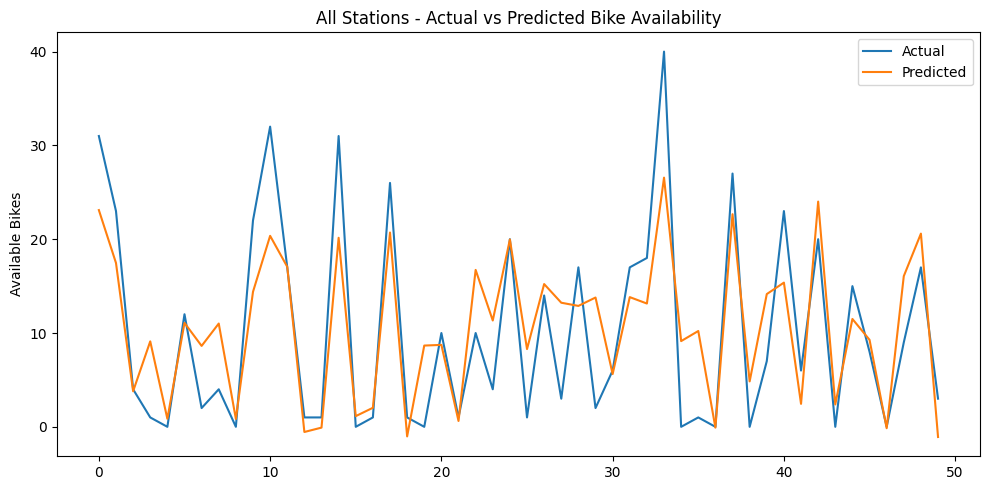

In [10]:
# Visualising actual vs predicted bike availability.
import matplotlib.pyplot as plt

# Getting first 50 predictions for clearer chart.
y_actual_all = y_test[:50].reset_index(drop=True)
y_predicted_all = y_pred[:50]

# Plotting.
plt.figure(figsize=(10, 5))
plt.plot(y_actual_all, label="Actual")
plt.plot(y_predicted_all, label="Predicted")
plt.title("All Stations - Actual vs Predicted Bike Availability")
plt.ylabel("Available Bikes")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

As can be seen above, this prediction model shows strong accuracy, capturing trends and timing of peaks, and somewhat correctly predicting availability. This will be tested further.

Let's save the model next.

In [11]:
import os
import pickle

# Getting unique "station_id".
station_ids = data['station_id'].unique()

# Creating new folder in current dir to store pickle files.
folder_path = "station_models"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Iterating over each unique station.
for station_id in station_ids:
    print(f"Training model for station {station_id}...")
    station_data = data[data['station_id'] == station_id]
    
    # Dropping appropriate columns as discussed previously.
    X = station_data.drop(columns=["station_id", "time", "num_bikes_available", "minute", "month", "year"])
    y = station_data["num_bikes_available"]

    # Random Forest Regressor model.
    model = RandomForestRegressor()
    model.fit(X, y)
    
    # Filename defined dynamically.
    model_filename = f"{folder_path}/station_{station_id}.pkl"
    
    # Saving model using pickle.
    with open(model_filename, 'wb') as f:
        pickle.dump(model, f)
    
    print(f"Model for station {station_id} saved to {model_filename}")

Training model for station 10...
Model for station 10 saved to station_models/station_10.pkl
Training model for station 100...
Model for station 100 saved to station_models/station_100.pkl
Training model for station 109...
Model for station 109 saved to station_models/station_109.pkl
Training model for station 11...
Model for station 11 saved to station_models/station_11.pkl
Training model for station 114...
Model for station 114 saved to station_models/station_114.pkl
Training model for station 116...
Model for station 116 saved to station_models/station_116.pkl
Training model for station 13...
Model for station 13 saved to station_models/station_13.pkl
Training model for station 14...
Model for station 14 saved to station_models/station_14.pkl
Training model for station 15...
Model for station 15 saved to station_models/station_15.pkl
Training model for station 17...
Model for station 17 saved to station_models/station_17.pkl
Training model for station 18...
Model for station 18 save

Let's test the ML model next with actual values from the CSV.

In [12]:
# Loading the trained model from the file using pickle.
with open("station_models/station_10.pkl", "rb") as file:
    model = pickle.load(file)

# Creating a test input row with exact values from the CSV.
test_input = pd.DataFrame([{
    "num_docks_available": 1,
    "day": 1,
    "hour": 0,
    "avg_air_temp": 13.955,
    "avg_humidity": 83.75,
    "day_name": 6
}])

# Predicting available bikes using the model.
prediction = model.predict(test_input)

# Printing result.
print(f"Predicted number of available bikes is {int(prediction[0])}")

Predicted number of available bikes is 15


This correctly predicted the number of available bikes for station 10. Let's test it again for a different station with exact values.

In [13]:
# Loading the trained model from the file using pickle.
with open("station_models/station_24.pkl", "rb") as file:
    model = pickle.load(file)

# Creating a test input row with exact values from the CSV.
test_input = pd.DataFrame([{
    "num_docks_available": 7,
    "day": 1,
    "hour": 0, 
    "avg_air_temp": 13.955,
    "avg_humidity": 83.75,
    "day_name": 6
}])

# Predicting available bikes using the model.
prediction = model.predict(test_input)

# Printing result.
print(f"Predicted number of available bikes is {int(prediction[0])}")

Predicted number of available bikes is 13
